<a href="https://colab.research.google.com/github/habiib1999/Speech-Emotion-Recognition/blob/main/zcr_TRAINtheMODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import os
import re
 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
import itertools

In [164]:

energy_data = np.load("/content/drive/MyDrive/emotionDataset/crema_zcr_data_feature2.npy",allow_pickle=True) 
energy_labels = np.load( "/content/drive/MyDrive/emotionDataset/crema_zcr_labels_feature2.npy",allow_pickle=True)
energy_labels = np.repeat(energy_labels, 5)

In [165]:
# FILL NaN
def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype=data.dtype)
    out[mask] = np.concatenate(data)
    return out
energy_data = numpy_fillna(energy_data)

**Hot Encoding for labels**

In [166]:
# Encode labels
lb = LabelEncoder()
energy_labels = np_utils.to_categorical(lb.fit_transform(energy_labels))
print(lb.classes_)
print(energy_labels)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [167]:
print(energy_labels.shape)

(37210, 6)


**Split Data to training, Test and Val**

In [168]:
# Split data
energy_train, energy_test, energy_label_train, energy_label_test = train_test_split(energy_data, energy_labels, test_size=0.1)

energy_train, energy_vald, energy_label_train, energy_label_vald = train_test_split(energy_train, energy_label_train, test_size=0.05) 

**Standardize data**

In [169]:
# Standardize data


print(energy_train)
scaler = StandardScaler()
energy_train = scaler.fit_transform(energy_train)
energy_test = scaler.transform(energy_test)
energy_vald = scaler.transform(energy_vald)


print(pd.DataFrame( energy_train))

[[0.03466796875 0.0556640625 0.07421875 ... 0 0 0]
 [0.05517578125 0.068359375 0.0830078125 ... 0 0 0]
 [0.02099609375 0.03857421875 0.052734375 ... 0 0 0]
 ...
 [0.06396484375 0.095703125 0.1201171875 ... 0.09375 0.068359375
  0.0390625]
 [0.02587890625 0.04541015625 0.05322265625 ... 0 0 0]
 [0.017578125 0.02490234375 0.0322265625 ... 0.0517578125 0.04443359375
  0.03271484375]]
            0         1         2    ...       105       106       107
0     -0.302093 -0.267219 -0.277566  ... -0.255332 -0.254712 -0.244650
1      0.095112 -0.098936 -0.187216  ... -0.255332 -0.254712 -0.244650
2     -0.566897 -0.493755 -0.498423  ... -0.255332 -0.254712 -0.244650
3     -0.566897 -0.552007 -0.503442  ... -0.255332 -0.254712 -0.244650
4     -0.547982 -0.552007 -0.603832  ... -0.255332 -0.254712 -0.244650
...         ...       ...       ...  ...       ...       ...       ...
31809 -0.746585 -0.778543 -0.809630  ... -0.255332 -0.254712 -0.244650
31810 -0.708756 -0.752653 -0.804610  ...  0.0521

In [170]:
# We have to use 1-dimensional CNN which need specifical shape:
energy_train = np.expand_dims(energy_train, axis=2)
energy_vald = np.expand_dims(energy_vald, axis=2)
energy_test = np.expand_dims(energy_test, axis=2)

print(energy_train.shape)

(31814, 108, 1)


# The Network


In [171]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [172]:
batch_size = 256
epochs = 30
num_classes = 6

In [173]:
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 2,
                              restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)
checkpoint_filepath = "/content/drive/MyDrive/emotionDataset"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#callback = EarlyStopping(monitor='loss', patience=3)

In [174]:
 '''
 model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(energy_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
'''

'\nmodel = models.Sequential()\nmodel.add(layers.Conv1D(512, kernel_size=5, strides=1,\n                       padding="same", activation="relu",\n                       input_shape=(energy_train.shape[1], 1)))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(layers.Conv1D(512, kernel_size=5, strides=1,\n                       padding="same", activation="relu"))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(layers.Conv1D(256, kernel_size=5, strides=1,\n                       padding="same", activation="relu"))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))\n\nmodel.add(layers.Conv1D(256, kernel_size=3, strides=1, padding=\'same\', activation=\'relu\'))\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = \'same\'))\n\nmodel.a

**Neural Network Architecture**

In [175]:

fashion_model = models.Sequential()

fashion_model.add(layers.Conv1D(16, kernel_size=3, strides=1,padding="same", activation='relu',input_shape=(energy_train.shape[1], 1)))
fashion_model.add(layers.ReLU())
fashion_model.add(layers.BatchNormalization())



fashion_model.add(layers.Conv1D(32, kernel_size=3, strides=1,padding="same", activation='relu'))
fashion_model.add(layers.ReLU())
fashion_model.add(layers.BatchNormalization())




fashion_model.add(layers.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
fashion_model.add(layers.ReLU())
fashion_model.add(layers.BatchNormalization())



fashion_model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
fashion_model.add(layers.ReLU())
fashion_model.add(layers.BatchNormalization())
fashion_model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


fashion_model.add(layers.Flatten())
fashion_model.add(layers.Dense(128, activation='relu'))
fashion_model.add(layers.Dropout(0.25))
fashion_model.add(layers.Dense(128, activation='relu'))
fashion_model.add(layers.Dropout(0.25))
fashion_model.add(layers.Dense(64, activation='relu'))
fashion_model.add(layers.Dropout(0.25))
fashion_model.add(layers.BatchNormalization())       
fashion_model.add(layers.Dense(num_classes, activation="softmax"))


**Compile the Model**

In [176]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='rmsprop',metrics=['accuracy'])
#fashion_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])


In [177]:
fashion_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 108, 16)           64        
_________________________________________________________________
re_lu_28 (ReLU)              (None, 108, 16)           0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 108, 16)           64        
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 108, 32)           1568      
_________________________________________________________________
re_lu_29 (ReLU)              (None, 108, 32)           0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 108, 32)           128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 108, 64)          

**Train the Model**

In [178]:
fashion_model.load_weights(checkpoint_filepath)
history = fashion_model.fit(energy_train, energy_label_train, validation_data=(energy_vald, energy_label_vald),epochs=epochs, batch_size=batch_size,   callbacks=[model_checkpoint_callback,learning_rate_reduction])


Epoch 1/30
125/125 [==============================] - 41s 303ms/step - loss: 0.3501 - accuracy: 0.8891 - val_loss: 0.1980 - val_accuracy: 0.9493
Epoch 2/30
125/125 [==============================] - 37s 298ms/step - loss: 0.3163 - accuracy: 0.8968 - val_loss: 0.2213 - val_accuracy: 0.9415
Epoch 3/30
125/125 [==============================] - 37s 298ms/step - loss: 0.2880 - accuracy: 0.9047 - val_loss: 0.2135 - val_accuracy: 0.9469

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 4/30
125/125 [==============================] - 37s 298ms/step - loss: 0.2585 - accuracy: 0.9166 - val_loss: 0.1928 - val_accuracy: 0.9546
Epoch 5/30
125/125 [==============================] - 37s 299ms/step - loss: 0.2374 - accuracy: 0.9227 - val_loss: 0.1973 - val_accuracy: 0.9493
Epoch 6/30
125/125 [==============================] - 37s 298ms/step - loss: 0.2333 - accuracy: 0.9242 - val_loss: 0.1950 - val_accuracy: 0.9522

Epoch 00006: ReduceLROnPlateau reducing learning

**Evalution On training and val**

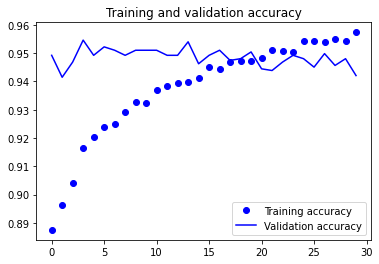

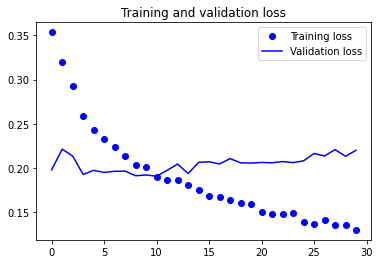

In [180]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Save/Reload Models**

In [181]:
from keras.models import load_model
fashion_model.save("/content/drive/MyDrive/emotionDataset/zcr_spec_model_best")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/emotionDataset/zcr_spec_model_best/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/emotionDataset/zcr_spec_model_best/assets


In [ ]:
my_model = load_model("/content/drive/MyDrive/emotionDataset/zcr_spec_model")
my_model.load_weights(checkpoint_filepath)

In [ ]:
my_model.summary()
history2 = my_model.fit(energy_train, energy_label_train, validation_data=(energy_vald, energy_label_vald),epochs=epochs, batch_size=batch_size,   callbacks=[learning_rate_reduction])


**Model Fine-Tuning**

In [ ]:
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.0001, decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

**Early Stopping**

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)
model3.fit(x_train4, y_train4, batch_size=32, epochs=15, validation_data=(x_test4, y_test4), callbacks=[early_stopping_monitor])